In [1]:
import torch
import random
from PIL import Image

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from util.datasets import build_dataset

from torchvision import datasets, transforms
from PIL import ImageFilter
import random

from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data.mixup import Mixup
from torchvision.transforms import v2

In [2]:
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


In [3]:
# Load your dataset and create a DataLoader
#dataset = '/media/gabriel/BA1041B410417881/Users/gabrielc/Datasets/all_plus_utad/train/'
dataset = '/home/gabriel/Downloads/castas-huge2-split/train/'

class Object(object):
    pass

args = Object()
args.data_dir = dataset
args.input_size = 224
args.color_jitter = None
args.aa = 'rand-m9-mstd0.5-inc1'
args.reprob = 0.25
args.remode = 'pixel'
args.recount = 1

transform = create_transform(
            input_size=args.input_size,
            is_training=True,
            color_jitter=args.color_jitter,
            auto_augment=args.aa,
            interpolation='bicubic',
            re_prob=args.reprob,
            re_mode=args.remode,
            re_count=args.recount,
        )

# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
augmentation = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

transform = transforms.Compose(augmentation)

ds = datasets.ImageFolder(dataset, transform=transforms.Compose([transforms.Resize(256)]))
ds2 = datasets.ImageFolder(dataset, transform=transform)
dataloader = torch.utils.data.DataLoader(ds2, batch_size=10, shuffle=True)

In [4]:
#mixup
mixup = 0.8
cutmix = 1.
cutmix_minmax = None
mixup_prob = 1.
mixup_switch_prob = .5
mixup_mode = 'batch'

#label smoothing
smoothing = 0.1
num_classes = len(ds.classes)
mixup_fn = None
mixup_active = mixup > 0 or cutmix > 0. or cutmix_minmax is not None
if mixup_active:
    print("Mixup is activated!")
    mixup_fn = Mixup(
        mixup_alpha=mixup, cutmix_alpha=cutmix, cutmix_minmax=cutmix_minmax,
        prob=mixup_prob, switch_prob=mixup_switch_prob, mode=mixup_mode,
        label_smoothing=smoothing, num_classes=num_classes)
    

mixup_v2 = v2.RandomChoice([v2.CutMix(num_classes=num_classes, alpha=cutmix), v2.MixUp(num_classes=num_classes, alpha=mixup)])

Mixup is activated!


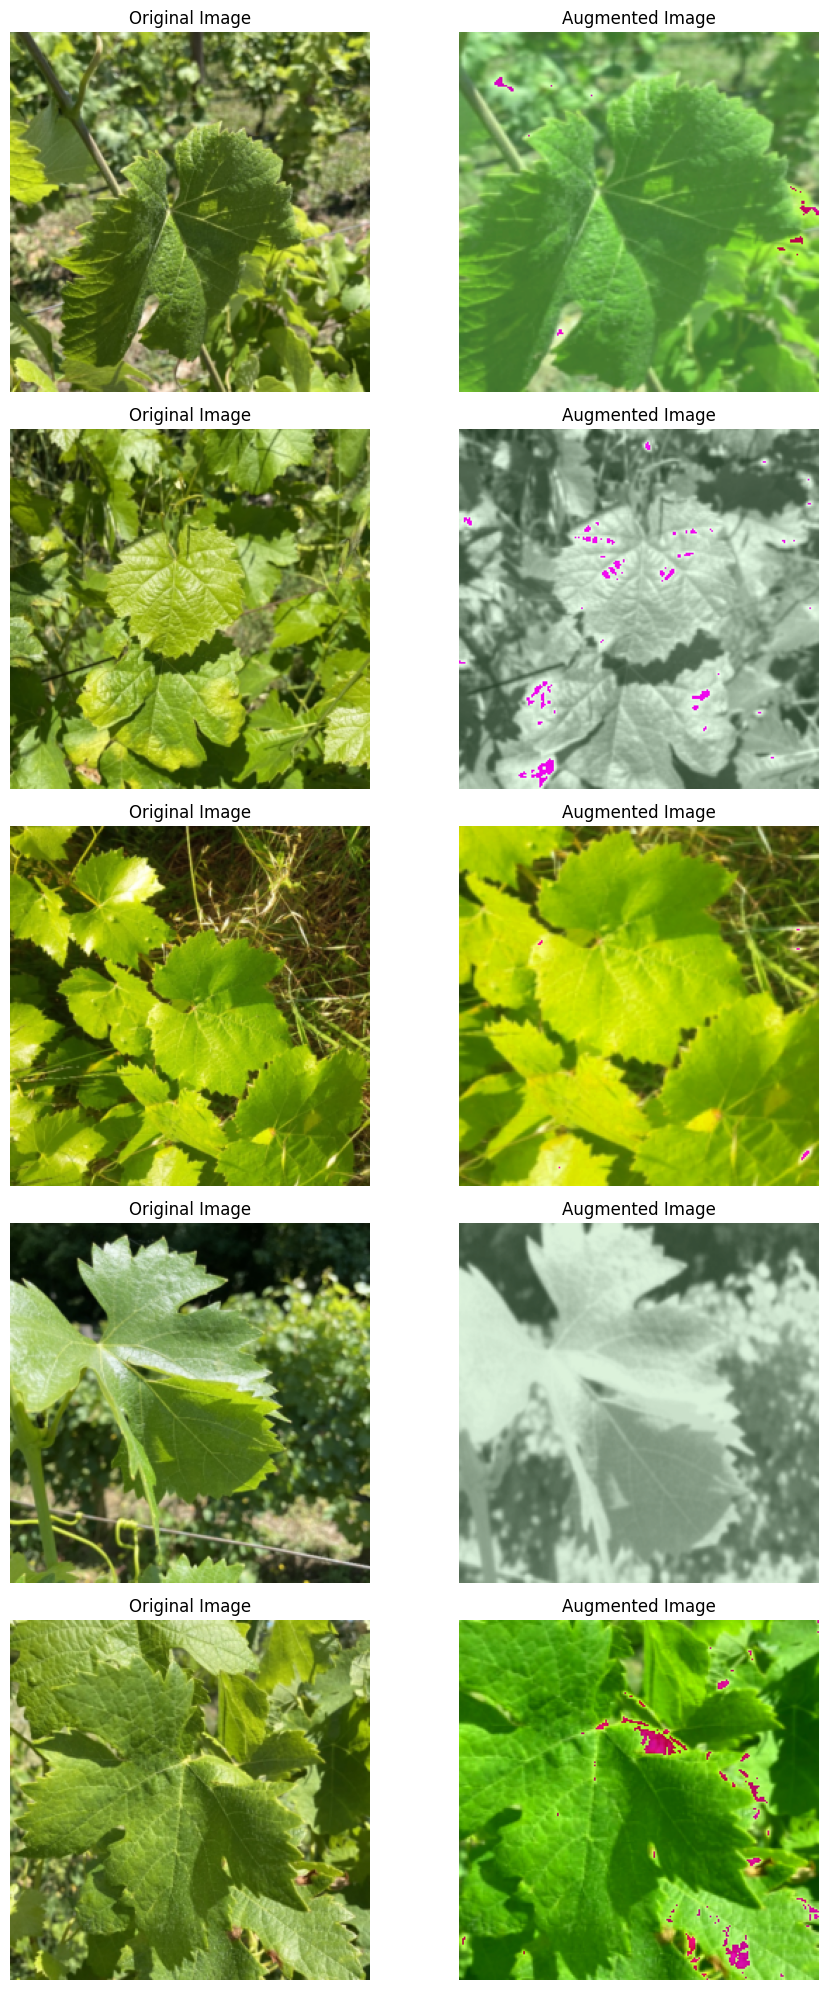

In [5]:
import random
# Visualize the original and augmented images
# Define the interval
start = 1
end = len(ds)

# Generate five random numbers within the interval
random_numbers = [ds[random.randint(start, end)] for _ in range(5)]
aux = transforms.Compose([transforms.Normalize(
    [-0.485/0.229, -0.546/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225]),
    transforms.ToPILImage()])

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i, image in enumerate(random_numbers):
    # Get the original image
    original_image = image[0]
    
    # Apply the transformations to the original image
    augmented_image = transform(original_image)
    augmented_image = aux(augmented_image)

    # Plot the original and augmented images side by side
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(augmented_image)
    axes[i, 1].set_title("Augmented Image")
    axes[i, 1].axis("off")

    if i == 4:
        break

plt.tight_layout()
plt.show()

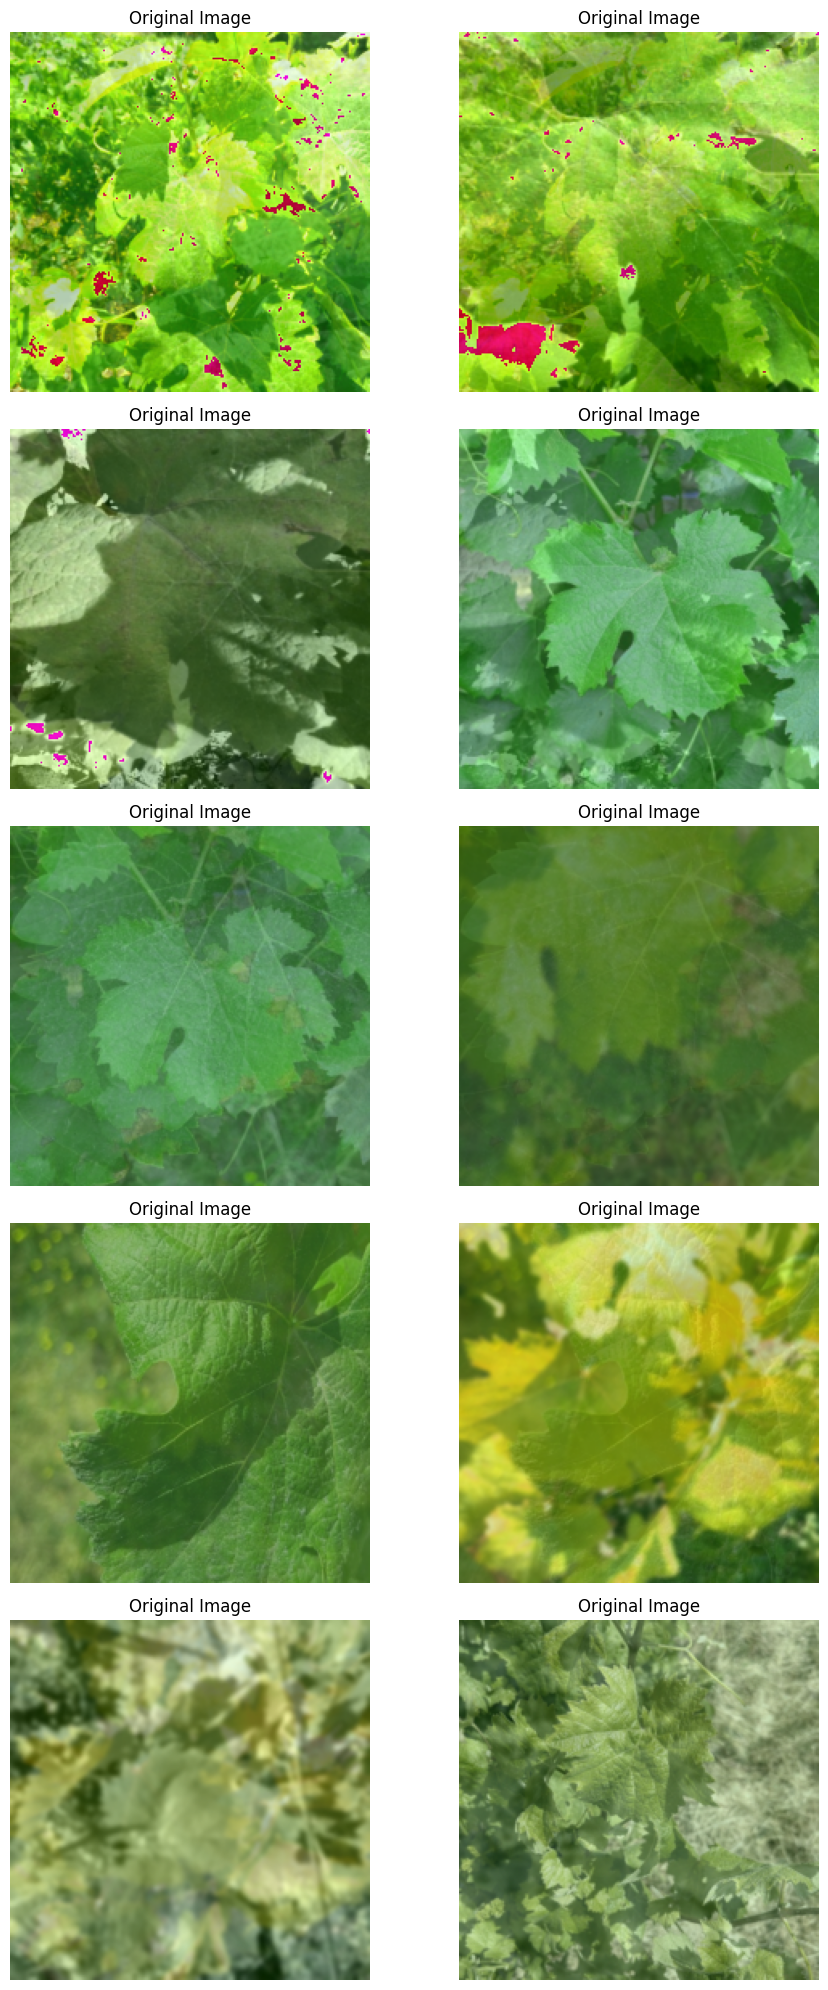

In [6]:
import random
# Visualize the original and augmented images
# Define the interval
aux = transforms.Compose([transforms.Normalize(
    [-0.485/0.229, -0.546/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225]),
    transforms.ToPILImage()])

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))


images, labels = dataloader.__iter__().__next__()
if mixup_fn is not None:
    #images, labels = mixup_fn(images, labels)
    images, labels = mixup_v2(images, labels)

for i, image in enumerate(images):
    # Plot the original and augmented images side by side

    image = aux(image)
    axes[int(i/2), int(i % 2)].imshow(image)
    axes[int(i/2), int(i % 2)].set_title("Original Image")
    axes[int(i/2), int(i % 2)].axis("off")


plt.tight_layout()
plt.show()

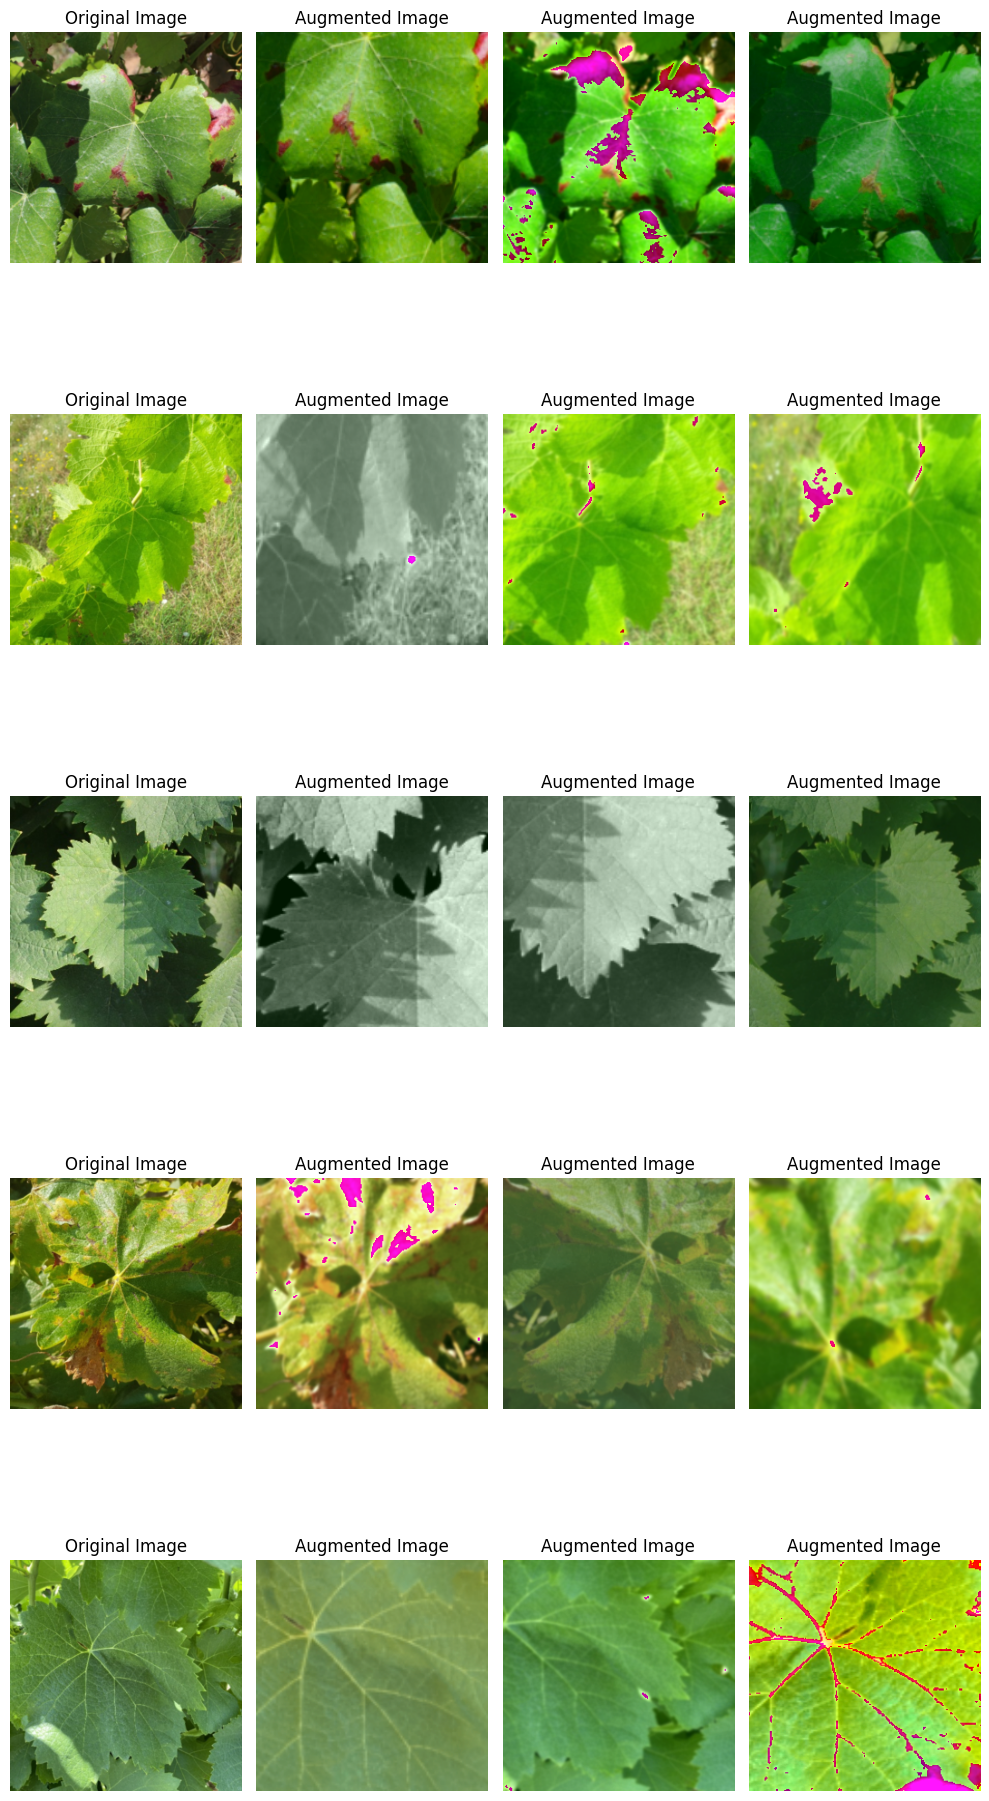

In [10]:
import random
# Visualize the original and augmented images
# Define the interval
start = 1
end = len(ds)

# Generate five random numbers within the interval
random_numbers = [ds[random.randint(start, end)] for _ in range(5)]
aux = transforms.Compose([transforms.Normalize(
    [-0.485/0.229, -0.546/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225]),
    transforms.ToPILImage()])

number_augmentation_per_image = 3
fig, axes = plt.subplots(nrows=5, ncols=1 + number_augmentation_per_image, figsize=(10, 20))

for i, image in enumerate(random_numbers):
    # Get the original image
    original_image = image[0]
    
    # Apply the transformations to the original image
    augmented_image = transform(original_image)
    augmented_image = aux(augmented_image)

    augmented_images = [aux(transform(original_image)) for k in range(number_augmentation_per_image)]

    # Plot the original and augmented images side by side
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    for k in range(number_augmentation_per_image):
        axes[i, k+1].imshow(augmented_images[k])
        axes[i, k+1].set_title("Augmented Image")
        axes[i, k+1].axis("off")

plt.tight_layout()
plt.show()